In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling,Dense,Dropout,Conv2D,Conv2DTranspose,MaxPool2D,Flatten,Input,Reshape
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential,Model
from sklearn.manifold import TSNE

In [159]:
# load data

train_dir,test_dir = "train_data_directory","test_data_directory"
batch = 32
chn = 3
img_h = 424
img_w = 424
img_shp = (img_h,img_w,chn)
seed = 42
val_split = 0.2

# load training set
train_ds = image_dataset_from_directory(train_dir,
    image_size = (img_h,img_w),
    batch_size = batch,
    validation_split = val_split,
    subset = "training",
    seed = seed,
    shuffle = False,
    labels = None,
    )

# load validation set
val_ds = image_dataset_from_directory(train_dir,
    image_size = (img_h,img_w),
    batch_size = batch,
    validation_split = val_split,
    subset = "validation",
    seed = seed,
    shuffle = False,   #Make sure that same set of validation is used in whole training
    labels = None,
    )

# load test set
test_ds = image_dataset_from_directory(test_dir,
    image_size = (img_h,img_w),
    batch_size = batch,
    shuffle = False,
    labels = None,
    )

Found 206901 files belonging to 1 classes.
Using 165521 files for training.
Found 206901 files belonging to 1 classes.
Using 41380 files for validation.
Found 11817 files belonging to 1 classes.


In [161]:
train_files = train_ds.file_paths
val_files = val_ds.file_paths
test_files = test_ds.file_paths

In [163]:
#cast to float32 from uint8 and prefetch data to GPU

train_ds = train_ds.map(lambda x: tf.cast(x,tf.float32)/255.0,num_parallel_calls = tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(lambda x: tf.cast(x,tf.float32)/255.0,num_parallel_calls = tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(lambda x: tf.cast(x,tf.float32)/255.0,num_parallel_calls = tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)


In [111]:
#Model

class vae(Model):
    
    def __init__(self,img_shape,latdim = 64):
        super().__init__()

        self.encoder = Sequential([
            Input(shape = img_shape),
            Conv2D(kernel_size = 16,
                   filters = 16,
                   kernel_initializer = VarianceScaling(),
                   strides = 4,
                   activation = relu,
                  ),                    #103x103x16
            MaxPool2D(pool_size = (5,5),
                         strides = 2,
                
            ),                          #50x50x16
            Conv2D(kernel_size = 4,
                   filters = 16,
                   kernel_initializer = VarianceScaling(),
                   strides = 2,
                   activation = relu,
            ),                          #24x24x16
            MaxPool2D(pool_size = (2,2),
                         strides = 2,
                        ),               #12x12x16
            Flatten(),                  # flatten to 12x12x16 = 2034 pixels
            Dense(512,activation = 'relu'),
            Dense(256,activation = 'relu'),
            Dense(128,activation = 'relu'), 
            
        ])
        
        self.mu = Dense(latdim,activation = 'linear')

        self.logvar = Dense(latdim,activation = 'linear')
        
        self.decoder = Sequential([
            Dense(2304,activation = 'relu'), # 64 --> 2034
            Reshape((12,12,16)),             # 2304 --> 16 fms of 12x12 size.
            Conv2DTranspose(filters = 16,
                            kernel_size = 2,
                            strides = 2,
                            activation = 'relu', 
                            ),                    #24x24x16
            Conv2DTranspose(filters = 16,
                            kernel_size = 4,
                            strides = 2,
                            activation = 'relu', 
                            ),                   #50x50x16
            Conv2DTranspose(filters = 16,
                            kernel_size = 5,
                            strides = 2,
                            activation = 'relu', 
                            ),                   #103x103x16
            Conv2DTranspose(filters = 3,
                            kernel_size = 16,
                            strides = 4,
                            activation = 'relu', 
                            ),                   #424x424x3 (RGB)
        ])


    def rep_trick(self,mu,logvar):
        
        eps = tf.random.normal(tf.shape(mu),0.0,1.0)
        std = tf.math.exp(0.5*logvar)
        z = mu + eps*std
        return z
        
    def encoder_out(self,X):
        
        enc = self.encoder(X)
        mu = self.mu(enc)
        logvar = self.logvar(enc)
        z = self.rep_trick(mu,logvar)
            
        return mu,logvar,z

    def decoder_out(self,z):
            
        back = self.decoder(z)

        return back
            
 
    @tf.function
    def loss(self,X,Xhat,mu,logvar,klw,recw):

        kl_loss = logvar - tf.math.exp(logvar) - tf.square(mu) + 1
        kl_loss = -0.5*tf.reduce_sum(kl_loss,axis = 1)               #scaling after computation
        batch_kl_loss = tf.reduce_mean(kl_loss)

        
        #MSE
        
        rec_loss = tf.square(X - Xhat)
        batch_rec_loss = tf.reduce_sum(rec_loss,axis = [1,2,3])
        per_img_rec_loss = tf.reduce_mean(batch_rec_loss)

        
        total_loss = klw * batch_kl_loss + recw *per_img_rec_loss

        return total_loss

    @tf.function
    def validate(self,val,klw,recw):

        val_mu,val_logvar,val_z = self.encoder_out(val)
        val_predicted = self.decoder_out(val_z)
        val_loss = self.loss(val,val_predicted,val_mu,val_logvar,klw,recw)

        return val_loss

    def get_latent_space(self,X):
        _,_,z = self.encoder_out(X)
        return z
        
        
    
    @tf.function
    def backprop(self,X,klw,recw,optimizer):

        with tf.GradientTape() as tape:
        
            mu,logvar,z = self.encoder_out(X)
            Xhat = self.decoder_out(z)
            loss = self.loss(X,Xhat,mu,logvar,klw,recw)

        grad = tape.gradient(loss,self.trainable_variables)
        optimizer.apply_gradients(zip(grad,self.trainable_variables))
    
        return loss

In [113]:
@tf.function
def train_step(x,model,klw,recw,optimizer):
    return model.backprop(x,klw,recw,optimizer)


In [115]:
@tf.function
def val_step(x,model,klw,recw):
    return model.validate(x,klw,recw)
    

In [117]:
def lat_space(X,model):
    z_hist = []
    for k in X:
        _,_,z = model.encoder_out(k)
        z_hist.append(z)
    return z_hist

In [119]:

def train(X,val,model,optimizer,klw = 1,recw = 1,epochs = 10):
    train_loss_hist = []
    val_loss_hist = []
    for i in range(epochs):
        
        batch_train_loss = 0.0
        num_train_batch = 0
        for j in X:
            train_loss = train_step(j,model,klw,recw,optimizer)
            batch_train_loss += train_loss
            num_train_batch += 1
            
        batch_val_loss = 0.0
        num_val_batch = 0
        for v in val:
            val_loss = val_step(v,model,klw,recw)
            batch_val_loss += val_loss
            num_val_batch += 1
            
        epoch_train_loss = batch_train_loss/num_train_batch
        epoch_val_loss = batch_val_loss/num_val_batch
        
        print(f"Epoch {i+1} training loss : {epoch_train_loss:.4f} | validation loss : {epoch_val_loss:.4f}")
        
        train_loss_hist.append(epoch_train_loss.numpy())
        val_loss_hist.append(epoch_val_loss.numpy())

        if i >= 1:
            if abs(train_loss_hist[-1] - train_loss_hist[-2]) < 1.0:
                break
    
    return train_loss_hist,val_loss_hist
 
    

In [121]:
# instantiate the model

model = vae(img_shp,latdim = 64)

In [125]:
#Train model

learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate)
kl_weight = 0.1
rec_weight = 1
epochs = 10
    
    
#train_loss_hist,val_loss_hist = train(train_ds,val_ds,model,optimizer,kl_weight,rec_weight,epochs)

In [51]:
def plot_loss(train_loss,validation_loss,epoch,save = True,path = loss_plot_file_path):

    epoch = np.linspace(1,epoch,epoch)
    fig,ax = plt.subplots(1,1,figsize = (6,6))
    ax.plot(epoch,train_loss,c = 'r',label = 'Train')
    ax.plot(epoch,validation_loss,c = 'b',label = 'Validation')
    ax.set_title('Train vs Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()

    if save == True:
        fig.savefig(path)
        print("Image saved at : ",path)

    return None
    

In [53]:
def plot_z(X,model,s,n=2,save = True,path = latent_space_file_path):
    
    z = lat_space(X,model)
    z_stacked = tf.concat(z, axis=0).numpy()

    emb = TSNE(n_components = n).fit_transform(z_stacked)
    
    print(z_stacked.shape)

    fig, ax = plt.subplots(1,1,figsize = (5,5))
    ax.scatter(emb[:,0],emb[:,1],s = s)
    ax.set_title('2D Latent Space')
    plt.show()

    if save == True:
        fig.savefig(path)
        print("Image saved at : ",path)

    
    return z_stacked
    


In [13]:
# Save paths

weight_file_path = "Weight_file_directory"
latent_space_file_path = "latent_space.png"
loss_plot_file_path = "loss_plot.png"
z_file_path = "z.npy"
train_loss_path = "train_loss.npy"
val_loss_path = "val_loss.npy"

In [29]:
#save weights

model.save_weights(weight_file_path)

In [ ]:
# save losses

np.save(train_loss_path,train_loss_hist)
np.save(val_loss_path,val_loss_hist)

(165521, 64)


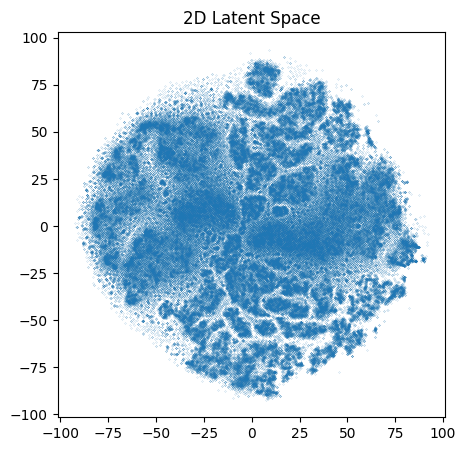

Image saved at :  E:/ML_Project/models/arc1/kl=0.1,rec=1,ep=10,sub,mse\Latent_space.png


In [55]:
#save z - latent space

#z_save = plot_z(train_ds,model,0.01)
np.save(z_file_path,z_save)

In [ ]:
#plot losses

#plot_loss(train_loss_hist,val_loss_hist,epochs)